# Impulse responses and convolution

In this notebook we will investigate an unknown digital system.
The only information we have about this system is that it is LTI (linear and time invariant) and that it is defined by the function `tools.blackbox()` in the file [tools.py](tools.py).

To be able to use it, we have to import it:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import soundfile as sf
import tools

After that, we have a look at the documentation of blackbox:

In [2]:
tools.blackbox?

In this notebook, we'll try to find out as many things as possible about this system, without looking at its source code.
Later, we'll also have a quick look at a non-linear system.

## Listening to the system

We load the audio file [data/xmas.wav](data/xmas.wav) and apply the function `tools.blackbox()` to it.

In [3]:
sig, fs = sf.read('data/xmas.wav')
fs

44100

We listen to the result. Compare the original signal and the resulting signal.
What does the system realized by `tools.blackbox()` sound like?

In [4]:
sig_blackbox = tools.blackbox(sig, fs)
sf.write('data/xmas_blackbox.wav', sig_blackbox, fs)

<audio src="data/xmas.wav" controls>Your browser does not support the audio element.</audio>
[data/xmas.wav](data/xmas.wav)

<audio src="data/xmas_blackbox.wav" controls>Your browser does not support the audio element.</audio>
[data/xmas_blackbox.wav](data/xmas_blackbox.wav)

## Obtaining the impulse response

As an LTI system can be completely described by its impulse response (which may be infinitely long, however), we generate one.

For that we start by creating a Dirac unit impulse.
To get a meaningful response, append zeros (this is called *zero-padding*) to your unit impulse signal until it has a total length of $\frac{1}{10}$ of a second.

In [5]:
dur = 1/10  # seconds
imp = np.zeros(int(np.ceil(dur * fs)))
imp[0] = 1

To do that, use a unit impulse as input to the system.
The resulting output is the impulse response.
To get a meaningful response, append zeros (this is called *zero-padding*) to your unit impulse signal until it has a total length of $\frac{1}{10}$ of a second.

Now we get the impulse response and look at it.

In [6]:
ir = tools.blackbox(imp, fs)

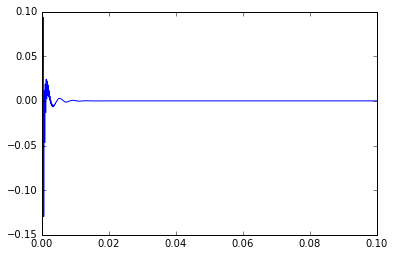

In [7]:
t = np.arange(len(imp)) / fs
plt.plot(t, ir)

Now we look at the transfer function, which can easily be calculated by using the function [scipy.signal.freqz()](http://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.freqz.html).

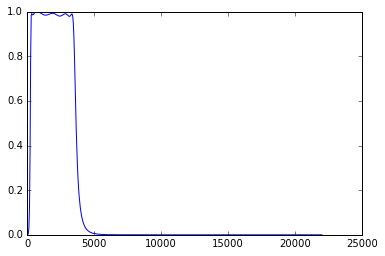

In [8]:
w, h = signal.freqz(ir)
plt.plot(w * fs / (2 * np.pi), np.abs(h))  # linear y axis

To obtain more insight about the parts of the impulse response with very small amplitudes, we can try logarithmic scaling.

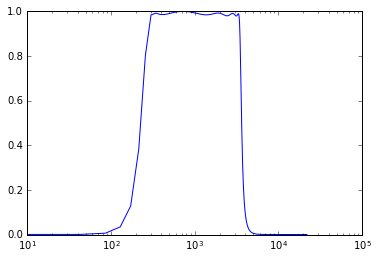

In [9]:
plt.figure()
plt.plot(w * fs / (2 * np.pi), np.abs(h))
plt.xscale('log') # logarithmic x axis

And finally we plot the magnitude in decibel.

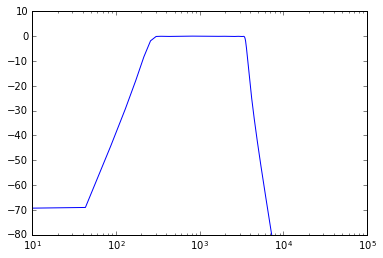

In [10]:
plt.plot(w * fs / (2 * np.pi), tools.db(h))
plt.xscale('log')
plt.ylim(-80, 10);

## Naive convolution versus fast convolution

Now we directly implement the convolution equation called `naive_convolution()` that computes the convolution of two one-dimensional arrays by means of two nested loops according to the equation

$$y(t) = x(t) \ast h(t) = \sum_{n=-\infty}^{\infty} x(n) \cdot h(t-n),$$

where $x$ and $h$ are one-dimensional arrays of finite lengths.
The infinite sum can be changed to a finite sum by assuming that all values before index 0 and all values after the last array element are equal to zero.

In [11]:
import numpy as np

def naive_convolution(x, h):
    """Very inefficient convolution of two one-dimensional arrays."""
    totalsize = len(x) + len(h) - 1
    y = np.zeros(totalsize)  # Allocate and initialize memory
    for t in range(totalsize):
        # n must be within range(len(x)) and it must meet the condition
        # t >= n and (t-n) < len(h)
        n_start = max(t + 1 - len(h), 0)
        n_stop = min(t + 1, len(x))
        for n in range(n_start, n_stop):
            y[t] += x[n] * h[t - n]
    return y

Now we use this function to convolve the audio signal with the impulse response we obtained above.

WARNING: The calculation may take a very long time!

In [12]:
# This takes a loooong time:
#sig_naive = naive_convolution(sig, ir)

# Let's just try a tiny bit of the signal:
%time sig_naive = naive_convolution(sig[:1000], ir)

CPU times: user 2.96 s, sys: 0 ns, total: 2.96 s
Wall time: 2.96 s


As you know, convolution in the time domain is equivalent to element-wise multiplication in the frequency domain.
This can be used for implementing the convolution in a more efficient way as we can see if we try to use the [numpy.convolve()](http://docs.scipy.org/doc/numpy/reference/generated/numpy.convolve.html) function from numpy.

In [13]:
%time sig_convolve = np.convolve(sig, ir)

CPU times: user 548 ms, sys: 0 ns, total: 548 ms
Wall time: 188 ms


## What if the System is Non-Linear?

The function `tools.blackbox_nonlinear()` provides a non-linear system.

We apply this system to our input signal and try to describe the non-linear system with an impulse response as well.

In [14]:
sig_blackbox_nonlinear = tools.blackbox_nonlinear(sig, fs)
sf.write('data/xmas_blackbox_nonlinear.wav', sig_blackbox_nonlinear, fs)

Now we are mesuring the impulse response of the non-linear system and use it to generate another output signal via convolution.

In [15]:
ir_nonlinear = tools.blackbox_nonlinear(imp, fs)
sig_nonlinear_convolve = np.convolve(sig, ir_nonlinear)
sf.write('data/xmas_convolution_nonlinear.wav', sig_nonlinear_convolve, fs)

<audio src="data/xmas.wav" controls>Your browser does not support the audio element.</audio>
[original](data/xmas.wav)

<audio src="data/xmas_blackbox.wav" controls>Your browser does not support the audio element.</audio>
[through `tools.blackbox()`](data/xmas_blackbox.wav)

<audio src="data/xmas_blackbox_nonlinear.wav" controls>Your browser does not support the audio element.</audio>
[through `tools.blackbox_nonlinear()`](data/xmas_blackbox_nonlinear.wav)

<audio src="data/xmas_convolution_nonlinear.wav" controls>Your browser does not support the audio element.</audio>
[trying to use the impulse response of the non-linear system (doesn't work!)](data/xmas_convolution_nonlinear.wav)

Non-linear systems CANNOT be described by their impulse responses.

<p xmlns:dct="http://purl.org/dc/terms/">
  <a rel="license"
     href="http://creativecommons.org/publicdomain/zero/1.0/">
    <img src="http://i.creativecommons.org/p/zero/1.0/88x31.png" style="border-style: none;" alt="CC0" />
  </a>
  <br />
  To the extent possible under law,
  <span rel="dct:publisher" resource="[_:publisher]">the person who associated CC0</span>
  with this work has waived all copyright and related or neighboring
  rights to this work.
</p>